Дорогой студент!

В домашнем задании Lite вам предлагается поработать подробнее с параметрами словаря и формированием гиперпараметров нейронной сети. Создайте 9 нейросетей с различными гиперпараметрами (см. пунтк 2 и 3)

 Для этого необходимо:

  1. Воссоздать ноутбук, аналогичный ноутбуку теоретической части, загрузив при этом необходимую нам базу (код уже доступен в ноутбуке).

  2. Задать в ноутбуке следующие параметры для размера словаря, ширины окна и шага:

    - Размер словаря - от 10000 до 20000 (выбрать меньшее значение диапазона, если будет перегрузка ОЗУ и перезапуск подключения к Colaboratory)
    - Ширина окна - от 1000 до 2000
    - Шаг - от 100 до 500 (на обучение лучше влияет наименьший шаг, но это может перегрузить ОЗУ).

  3. Создать архитектуру сети и задать гиперпараметры. Можно воспользоваться шаблоном:
  
   - Добавьте модель прямого распространения **Sequential()**
   - Добавьте один или несколько полносвязных (**Dense**) слоёв
   - Добавьте слои **Dropout()** и **BatchNormalization()**
   - Добавьте выходной полносвязный слой с количеством нейронов, соответствующим количеству классов (число писателей)
  
   Напомним, что точность сети можно проверить по значению показателя 'val_accuracy' на конце каждой эпохи.
   

## Подготовка

**Шаг 1**. Загрузка бибилиотек и базы данных.

Подключаем необходимые библиотеки и модули:

In [ ]:
# Работа с массивами данных
import numpy as np

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Работа с google диском
from google.colab import drive

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Регулярные выражения
import re
import time
import matplotlib.pyplot as plt

Потом загружаем датасет с текстами писателей в виде архива и распаковываем его в папку:

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/writers.zip', None, quiet=True)

# Распаковка архива в папку writers
!unzip -qo writers.zip -d writers/

# Просмотр содержимого папки
!ls writers

'(Булгаков) Обучающая_5 вместе.txt'
'(Булгаков) Тестовая_2 вместе.txt'
'(Клиффорд_Саймак) Обучающая_5 вместе.txt'
'(Клиффорд_Саймак) Тестовая_2 вместе.txt'
'(Макс Фрай) Обучающая_5 вместе.txt'
'(Макс Фрай) Тестовая_2 вместе.txt'
'(О. Генри) Обучающая_50 вместе.txt'
'(О. Генри) Тестовая_20 вместе.txt'
'(Рэй Брэдберри) Обучающая_22 вместе.txt'
'(Рэй Брэдберри) Тестовая_8 вместе.txt'
'(Стругацкие) Обучающая_5 вместе.txt'
'(Стругацкие) Тестовая_2 вместе.txt'


Сохраните в отдельных переменных:

   - Имя для папки с текстами
   - Название выборки "обучающая"
   - Название выборки "тестовая"

In [ ]:
# Папка с текстовыми файлами
FILE_DIR  = 'writers'

# Признак обучающей выборки в имени файла
SIG_TRAIN = 'обучающая'

# Признак тестовой выборки в имени файла
SIG_TEST  = 'тестовая'

**Шаг 2.** Преобразование базы данных для обучения.

Добавляем имена всех писателей в список классов.

Воспроизводим блок кода, где преобразуем тексты в одну длинную строку и разбиваем их отдельно в списки для каждого класса и выборки.

In [ ]:
# В список добавляются имена классов
CLASS_LIST = []

# Здесь сохраняются тексты для обучения сети
text_train = []

# А здесь для проверки точности сети
text_test = []

# цикл для итерации по каждому имени текста в общей папке
for file_name in os.listdir(FILE_DIR):

    # Выделение имени класса и типа выборки из имени файла
    m = re.match('\((.+)\) (\S+)_', file_name)

    # Если выделение получилось, то файл обрабатывается
    if m:

        # отдельно берём имя класса (автора)
        class_name = m[1]

        # отдельно - имя выборки
        subset_name = m[2].lower()

        # Проверка типа выборки по названию в имени файла
        is_train = SIG_TRAIN in subset_name
        is_test = SIG_TEST in subset_name

        # Если тип выборки обучающая или тестовая - файл обрабатывается
        if is_train or is_test:

            # Добавление нового класса, если его еще нет в списке
            if class_name not in CLASS_LIST:

                # Выводится информационное сообщение о добавлении названия класса
                CLASS_LIST.append(class_name)

                # Инициализация соответствующих классу строк текста
                text_train.append('')
                text_test.append('')

            # Поиск индекса класса для добавления содержимого файла в выборку
            cls = CLASS_LIST.index(class_name)

            # Выводится информационное сообщение о добавлении класса в список классов и текста к выборке
            print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}", {subset_name} выборка.')

            # оператор with - безопасное чтение каждого файла с текстом
            with open(f'{FILE_DIR}/{file_name}', 'r') as f:

                # Загрузка содержимого файла в строку
                text = f.read()

            # Определение выборки, куда будет добавлено содержимое
            subset = text_train if is_train else text_test

            # Добавление текста к соответствующей выборке класса. Концы строк заменяются на пробел
            subset[cls] += ' ' + text.replace('\n', ' ')

# Определим кол-во классов
CLASS_COUNT = len(CLASS_LIST)

Добавление файла "(Стругацкие) Тестовая_2 вместе.txt" в класс "Стругацкие", тестовая выборка.
Добавление файла "(Клиффорд_Саймак) Тестовая_2 вместе.txt" в класс "Клиффорд_Саймак", тестовая выборка.
Добавление файла "(Макс Фрай) Обучающая_5 вместе.txt" в класс "Макс Фрай", обучающая выборка.
Добавление файла "(Клиффорд_Саймак) Обучающая_5 вместе.txt" в класс "Клиффорд_Саймак", обучающая выборка.
Добавление файла "(Булгаков) Обучающая_5 вместе.txt" в класс "Булгаков", обучающая выборка.
Добавление файла "(Стругацкие) Обучающая_5 вместе.txt" в класс "Стругацкие", обучающая выборка.
Добавление файла "(Булгаков) Тестовая_2 вместе.txt" в класс "Булгаков", тестовая выборка.
Добавление файла "(Рэй Брэдберри) Тестовая_8 вместе.txt" в класс "Рэй Брэдберри", тестовая выборка.
Добавление файла "(Макс Фрай) Тестовая_2 вместе.txt" в класс "Макс Фрай", тестовая выборка.
Добавление файла "(Рэй Брэдберри) Обучающая_22 вместе.txt" в класс "Рэй Брэдберри", обучающая выборка.
Добавление файла "(О. Генри) 

Подготовьте текстовую инфрмацию для обработки Токенайзером. Для этого сохраните в подходящих именах переменных следующие параметры:

   - Объем словаря для токенизатора
   - Длина отрезка текста (окна) в словах
   - Шаг смещения окна по тексту для деления на векторы

И затем вызовите сам Токенайзер, передав в его параметры эти переменные и оставшиеся значения для преобразования.

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 15000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 3000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 300

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

Отдельно обучите сам Токенайзер на выборке текстов для обучения сети:


In [ ]:
# Получаем словарь частотности
tokenizer.fit_on_texts(text_train)

Преобразуйте обучающие и проверочные тексты в последовательность индексов согласно частотному словарю Токенайзера:

In [ ]:
seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

**Шаг 3.** Создание функций для формирования выборок. Формирование выборок.

Воспроизведите блок кода с двумя функциями:

  1. Функция деления последовательности индексов на отрезки скользящим окном

In [ ]:
def split_sequence(sequence,   # Последовательность индексов
                   win_size,   # Размер окна для деления на примеры
                   hop):       # Шаг окна

    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

 2. Функция формирования выборок из индексов и соответствующих классам меток в формате One Hot Encoding

In [ ]:
def vectorize_sequence(seq_list,    # Список последовательностей индексов
                       win_size,    # Размер окна для деления на примеры
                       hop):        # Шаг окна

    # В списке последовательности следуют в порядке их классов (их кол-во сповпадает с кол-вом классов)
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):

        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)

        # Добавление отрезков в выборку

        x += vectors

        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

Сформируйте выборки (x_train, y_train) и (x_test, y_test) с помощью функций, воспроизведённых в ячейке выше:

In [ ]:
# Формирование обучающей выборки
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
# Формирование тестовой выборки
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Проверка формы сформированных данных
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5842, 3000) (5842, 6)
(2190, 3000) (2190, 6)


Сформируем выборки индексов слов в виде матриц Bag Of Words методом  **sequences_to_matrix( )**.

In [ ]:
# На входе .sequences_to_matrix() ожидает список, .tolist() выполняет преобразование к типу данных 'список'
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

# Выводим форму обучающей выборки в виде матрицы Bag of Words
print(x_train_01.shape)
# Выводим фрагмент отрезка обучающего текста в виде Bag of Words
print(x_train_01[0][0:100])

(5842, 15000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


**Шаг 4.** Создание архитектуры нейронной сети.

Создайте несложную архитектуру нейронной сети. После этого произведите компиляцию модели с соответствующими параметрами:

In [ ]:
model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Обучите модель нейронной сети и посмотрите на результаты точности на проверочной выборке:

In [ ]:
results = []
acc = []
val_acc = []
loss = []
val_loss = []

In [ ]:
# Обучение сети с помощью функции fit()
begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
183/183 [==============================] - 12s 55ms/step - loss: 0.1100 - accuracy: 0.9795 - val_loss: 0.3309 - val_accuracy: 0.9447
Epoch 2/20
183/183 [==============================] - 14s 76ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.2961 - val_accuracy: 0.9347
Epoch 3/20
183/183 [==============================] - 10s 54ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.3056 - val_accuracy: 0.9164
Epoch 4/20
183/183 [==============================] - 6s 35ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2865 - val_accuracy: 0.9183
Epoch 5/20
183/183 [==============================] - 7s 41ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2864 - val_accuracy: 0.9137
Epoch 6/20
183/183 [==============================] - 6s 35ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2621 - val_accuracy: 0.9228
Epoch 7/20
183/183 [==============================] - 7s 40ms/step - loss: 9.0191e-04 - accuracy: 1.0000 - val_loss: 0.2604 - val_accuracy:

Запишите результаты в таблицу:

In [ ]:
results.append(('Модель:', 1, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

In [ ]:
print(results)

[('Модель:', 1, 'Объём словаря:', 15000, 'Длина окна:', 3000, 'Шаг окна:', 300, 'Точность:', 0.9178, 'Время выполнения:', 204.19)]


# **2 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 10000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 1000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 100

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

In [ ]:
# Получаем словарь частотности
tokenizer.fit_on_texts(text_train)

In [ ]:
seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

In [ ]:
# Формирование обучающей выборки
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
# Формирование тестовой выборки
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Проверка формы сформированных данных
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(17640, 1000) (17640, 6)
(6686, 1000) (6686, 6)


In [ ]:
# На входе .sequences_to_matrix() ожидает список, .tolist() выполняет преобразование к типу данных 'список'
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

# Выводим форму обучающей выборки в виде матрицы Bag of Words
print(x_train_01.shape)
# Выводим фрагмент отрезка обучающего текста в виде Bag of Words
print(x_train_01[0][0:100])

(17640, 10000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 1.]


In [ ]:
model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Обучение сети с помощью функции fit()
begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
552/552 [==============================] - 16s 27ms/step - loss: 0.0713 - accuracy: 0.9836 - val_loss: 0.3649 - val_accuracy: 0.8803
Epoch 2/20
552/552 [==============================] - 14s 25ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3572 - val_accuracy: 0.8781
Epoch 3/20
552/552 [==============================] - 14s 25ms/step - loss: 6.4219e-04 - accuracy: 1.0000 - val_loss: 0.3576 - val_accuracy: 0.8775
Epoch 4/20
552/552 [==============================] - 14s 25ms/step - loss: 3.4477e-04 - accuracy: 1.0000 - val_loss: 0.3466 - val_accuracy: 0.8802
Epoch 5/20
552/552 [==============================] - 14s 25ms/step - loss: 2.1302e-04 - accuracy: 1.0000 - val_loss: 0.3490 - val_accuracy: 0.8797
Epoch 6/20
552/552 [==============================] - 15s 26ms/step - loss: 1.4189e-04 - accuracy: 1.0000 - val_loss: 0.3432 - val_accuracy: 0.8817
Epoch 7/20
552/552 [==============================] - 14s 25ms/step - loss: 1.0467e-04 - accuracy: 1.0000 - val_loss: 0.

In [ ]:
results.append(('Модель:', 2, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **3 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 10000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 1000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 500

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
111/111 [==============================] - 4s 26ms/step - loss: 0.3176 - accuracy: 0.9281 - val_loss: 0.6771 - val_accuracy: 0.7881
Epoch 2/20
111/111 [==============================] - 3s 25ms/step - loss: 0.0352 - accuracy: 0.9997 - val_loss: 0.5378 - val_accuracy: 0.8231
Epoch 3/20
111/111 [==============================] - 8s 69ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.4877 - val_accuracy: 0.8433
Epoch 4/20
111/111 [==============================] - 5s 41ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.4373 - val_accuracy: 0.8545
Epoch 5/20
111/111 [==============================] - 3s 24ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.4211 - val_accuracy: 0.8590
Epoch 6/20
111/111 [==============================] - 3s 26ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.4086 - val_accuracy: 0.8642
Epoch 7/20
111/111 [==============================] - 3s 30ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.3960 - val_accuracy: 0.8649

In [ ]:
results.append(('Модель:', 3, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **4 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 10000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 2000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 100

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
550/550 [==============================] - 16s 27ms/step - loss: 0.0561 - accuracy: 0.9898 - val_loss: 0.3100 - val_accuracy: 0.9114
Epoch 2/20
550/550 [==============================] - 16s 28ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2947 - val_accuracy: 0.9021
Epoch 3/20
550/550 [==============================] - 14s 26ms/step - loss: 8.0122e-04 - accuracy: 1.0000 - val_loss: 0.2735 - val_accuracy: 0.9037
Epoch 4/20
550/550 [==============================] - 14s 25ms/step - loss: 3.9350e-04 - accuracy: 1.0000 - val_loss: 0.2793 - val_accuracy: 0.9016
Epoch 5/20
550/550 [==============================] - 15s 26ms/step - loss: 2.4521e-04 - accuracy: 1.0000 - val_loss: 0.2415 - val_accuracy: 0.9101
Epoch 6/20
550/550 [==============================] - 14s 26ms/step - loss: 1.4393e-04 - accuracy: 1.0000 - val_loss: 0.2674 - val_accuracy: 0.9018
Epoch 7/20
550/550 [==============================] - 14s 26ms/step - loss: 1.0084e-04 - accuracy: 1.0000 - val_loss: 0.

In [ ]:
results.append(('Модель:', 4, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **5 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 10000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 2000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 500

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
110/110 [==============================] - 5s 36ms/step - loss: 0.1801 - accuracy: 0.9602 - val_loss: 0.5340 - val_accuracy: 0.8283
Epoch 2/20
110/110 [==============================] - 3s 24ms/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.3225 - val_accuracy: 0.9209
Epoch 3/20
110/110 [==============================] - 3s 24ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.3113 - val_accuracy: 0.9300
Epoch 4/20
110/110 [==============================] - 3s 23ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2997 - val_accuracy: 0.9262
Epoch 5/20
110/110 [==============================] - 3s 28ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.2918 - val_accuracy: 0.9217
Epoch 6/20
110/110 [==============================] - 3s 28ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2893 - val_accuracy: 0.9172
Epoch 7/20
110/110 [==============================] - 3s 24ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2859 - val_accuracy: 0.9194

In [ ]:
results.append(('Модель:', 5, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **6 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 15000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 1000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 100

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
552/552 [==============================] - 23s 39ms/step - loss: 0.0490 - accuracy: 0.9897 - val_loss: 0.3843 - val_accuracy: 0.8717
Epoch 2/20
552/552 [==============================] - 22s 39ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3628 - val_accuracy: 0.8757
Epoch 3/20
552/552 [==============================] - 20s 37ms/step - loss: 5.3410e-04 - accuracy: 1.0000 - val_loss: 0.3381 - val_accuracy: 0.8836
Epoch 4/20
552/552 [==============================] - 22s 40ms/step - loss: 2.9543e-04 - accuracy: 1.0000 - val_loss: 0.3465 - val_accuracy: 0.8790
Epoch 5/20
552/552 [==============================] - 22s 39ms/step - loss: 1.7803e-04 - accuracy: 1.0000 - val_loss: 0.3679 - val_accuracy: 0.8739
Epoch 6/20
552/552 [==============================] - 20s 37ms/step - loss: 1.1690e-04 - accuracy: 1.0000 - val_loss: 0.3763 - val_accuracy: 0.8672
Epoch 7/20
552/552 [==============================] - 21s 38ms/step - loss: 7.7954e-05 - accuracy: 1.0000 - val_loss: 0.

In [ ]:
results.append(('Модель:', 6, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **7 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 15000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 1000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 500

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
111/111 [==============================] - 8s 45ms/step - loss: 0.2849 - accuracy: 0.9354 - val_loss: 0.7955 - val_accuracy: 0.7403
Epoch 2/20
111/111 [==============================] - 4s 35ms/step - loss: 0.0266 - accuracy: 0.9997 - val_loss: 0.5684 - val_accuracy: 0.8127
Epoch 3/20
111/111 [==============================] - 5s 43ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.4618 - val_accuracy: 0.8463
Epoch 4/20
111/111 [==============================] - 4s 35ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.4500 - val_accuracy: 0.8455
Epoch 5/20
111/111 [==============================] - 4s 36ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.3927 - val_accuracy: 0.8672
Epoch 6/20
111/111 [==============================] - 5s 44ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.4227 - val_accuracy: 0.8500
Epoch 7/20
111/111 [==============================] - 4s 36ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4345 - val_accuracy: 0.8440

In [ ]:
results.append(('Модель:', 7, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **8 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 15000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 2000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 100

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
550/550 [==============================] - 23s 39ms/step - loss: 0.0478 - accuracy: 0.9915 - val_loss: 0.3163 - val_accuracy: 0.9150
Epoch 2/20
550/550 [==============================] - 21s 38ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2950 - val_accuracy: 0.9108
Epoch 3/20
550/550 [==============================] - 20s 36ms/step - loss: 6.8526e-04 - accuracy: 1.0000 - val_loss: 0.2682 - val_accuracy: 0.9155
Epoch 4/20
550/550 [==============================] - 21s 38ms/step - loss: 3.6168e-04 - accuracy: 1.0000 - val_loss: 0.2834 - val_accuracy: 0.9028
Epoch 5/20
550/550 [==============================] - 21s 39ms/step - loss: 2.4012e-04 - accuracy: 1.0000 - val_loss: 0.2654 - val_accuracy: 0.9094
Epoch 6/20
550/550 [==============================] - 20s 36ms/step - loss: 1.4535e-04 - accuracy: 1.0000 - val_loss: 0.2494 - val_accuracy: 0.9170
Epoch 7/20
550/550 [==============================] - 21s 38ms/step - loss: 9.9148e-05 - accuracy: 1.0000 - val_loss: 0.

In [ ]:
results.append(('Модель:', 8, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **9 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 15000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 2000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 500

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
110/110 [==============================] - 6s 43ms/step - loss: 0.1964 - accuracy: 0.9562 - val_loss: 0.4614 - val_accuracy: 0.8742
Epoch 2/20
110/110 [==============================] - 4s 35ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.4088 - val_accuracy: 0.8697
Epoch 3/20
110/110 [==============================] - 4s 39ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.3572 - val_accuracy: 0.8893
Epoch 4/20
110/110 [==============================] - 4s 40ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.3597 - val_accuracy: 0.8840
Epoch 5/20
110/110 [==============================] - 4s 35ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.3493 - val_accuracy: 0.8901
Epoch 6/20
110/110 [==============================] - 4s 39ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.3553 - val_accuracy: 0.8863
Epoch 7/20
110/110 [==============================] - 4s 40ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3528 - val_accuracy: 0.8833

In [ ]:
results.append(('Модель:', 9, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **10 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 20000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 1000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 100

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
552/552 [==============================] - 36s 60ms/step - loss: 0.0529 - accuracy: 0.9908 - val_loss: 0.3906 - val_accuracy: 0.8654
Epoch 2/20
552/552 [==============================] - 29s 53ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.3721 - val_accuracy: 0.8687
Epoch 3/20
552/552 [==============================] - 31s 57ms/step - loss: 7.3744e-04 - accuracy: 1.0000 - val_loss: 0.3461 - val_accuracy: 0.8753
Epoch 4/20
552/552 [==============================] - 28s 51ms/step - loss: 3.8870e-04 - accuracy: 1.0000 - val_loss: 0.3319 - val_accuracy: 0.8784
Epoch 5/20
552/552 [==============================] - 28s 51ms/step - loss: 2.2695e-04 - accuracy: 1.0000 - val_loss: 0.3231 - val_accuracy: 0.8827
Epoch 6/20
552/552 [==============================] - 28s 51ms/step - loss: 1.6140e-04 - accuracy: 1.0000 - val_loss: 0.3541 - val_accuracy: 0.8669
Epoch 7/20
552/552 [==============================] - 29s 53ms/step - loss: 1.0426e-04 - accuracy: 1.0000 - val_loss: 0.

In [ ]:
results.append(('Модель:', 10, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **11 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 20000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 1000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 500

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
111/111 [==============================] - 7s 48ms/step - loss: 0.2204 - accuracy: 0.9490 - val_loss: 0.6679 - val_accuracy: 0.7873
Epoch 2/20
111/111 [==============================] - 6s 55ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.4429 - val_accuracy: 0.8866
Epoch 3/20
111/111 [==============================] - 5s 47ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.4124 - val_accuracy: 0.8873
Epoch 4/20
111/111 [==============================] - 5s 46ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.4102 - val_accuracy: 0.8843
Epoch 5/20
111/111 [==============================] - 6s 55ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4145 - val_accuracy: 0.8761
Epoch 6/20
111/111 [==============================] - 5s 49ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3923 - val_accuracy: 0.8836
Epoch 7/20
111/111 [==============================] - 6s 54ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3913 - val_accuracy: 0.8821

In [ ]:
results.append(('Модель:', 11, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **12 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 20000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 2000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 100

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
550/550 [==============================] - 30s 52ms/step - loss: 0.0553 - accuracy: 0.9920 - val_loss: 0.3207 - val_accuracy: 0.9267
Epoch 2/20
550/550 [==============================] - 28s 50ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2925 - val_accuracy: 0.9298
Epoch 3/20
550/550 [==============================] - 29s 52ms/step - loss: 7.9897e-04 - accuracy: 1.0000 - val_loss: 0.2608 - val_accuracy: 0.9340
Epoch 4/20
550/550 [==============================] - 28s 51ms/step - loss: 4.2879e-04 - accuracy: 1.0000 - val_loss: 0.2531 - val_accuracy: 0.9304
Epoch 5/20
550/550 [==============================] - 30s 54ms/step - loss: 2.3545e-04 - accuracy: 1.0000 - val_loss: 0.2471 - val_accuracy: 0.9313
Epoch 6/20
550/550 [==============================] - 27s 50ms/step - loss: 1.6426e-04 - accuracy: 1.0000 - val_loss: 0.2469 - val_accuracy: 0.9292
Epoch 7/20
550/550 [==============================] - 27s 49ms/step - loss: 1.0917e-04 - accuracy: 1.0000 - val_loss: 0.

In [ ]:
results.append(('Модель:', 12, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

# **13 модель**

In [ ]:
# Объем словаря для токенизатора
VOCAB_SIZE = 20000

# Длина отрезка текста (окна) в словах
WIN_SIZE   = 2000

# Шаг окна разбиения текста на векторы
WIN_HOP    = 500

# Токенайзер из Keras для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

tokenizer.fit_on_texts(text_train)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(184, input_dim=VOCAB_SIZE, activation="relu"))  # Первый полносвязный слой
model_BoW.add(Dense(86, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(Dense(33, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(CLASS_COUNT, activation='sigmoid'))             # Выходной полносвязный слой

model_BoW.compile(optimizer='adam',                                 # Компиляция модели для обучения на данных вида Bag of Words
              loss='categorical_crossentropy',
              metrics=['accuracy'])

begin = time.time()
history = model_BoW.fit(x_train_01,                            # Обучающая выборка Bag of Words
                        y_train,                               # Метки классов обучающей выборки
                        epochs=20,                             # Количество эпох
                        batch_size=32,                         # Размер подвыборки для одного шага по данным на эпохе
                        validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки
end = time.time()
diff = end - begin

Epoch 1/20
110/110 [==============================] - 9s 70ms/step - loss: 0.2124 - accuracy: 0.9602 - val_loss: 0.5898 - val_accuracy: 0.8321
Epoch 2/20
110/110 [==============================] - 6s 53ms/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.4695 - val_accuracy: 0.8622
Epoch 3/20
110/110 [==============================] - 6s 52ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.3817 - val_accuracy: 0.9096
Epoch 4/20
110/110 [==============================] - 5s 46ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.3386 - val_accuracy: 0.9285
Epoch 5/20
110/110 [==============================] - 6s 59ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.3219 - val_accuracy: 0.9315
Epoch 6/20
110/110 [==============================] - 5s 46ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.3008 - val_accuracy: 0.9367
Epoch 7/20
110/110 [==============================] - 6s 58ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3078 - val_accuracy: 0.9292

In [ ]:
results.append(('Модель:', 13, 'Объём словаря:', VOCAB_SIZE, 'Длина окна:', WIN_SIZE, 'Шаг окна:', WIN_HOP, 'Точность:', round(history.history['val_accuracy'][-1], 4), 'Время выполнения:', round(diff, 2)))
acc.append(history.history['accuracy'])
val_acc.append(history.history['val_accuracy'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

In [ ]:
copy = results

In [ ]:
data = {}

In [ ]:
for i, el in enumerate(copy):
  data[f'Модель {i+1}'] = el[11]
print(data)

{'Модель 1': 204.19, 'Модель 2': 324.63, 'Модель 3': 83.3, 'Модель 4': 291.04, 'Модель 5': 59.67, 'Модель 6': 422.81, 'Модель 7': 145.14, 'Модель 8': 417.1, 'Модель 9': 143.74, 'Модель 10': 603.96, 'Модель 11': 143.75, 'Модель 12': 565.88, 'Модель 13': 116.59}


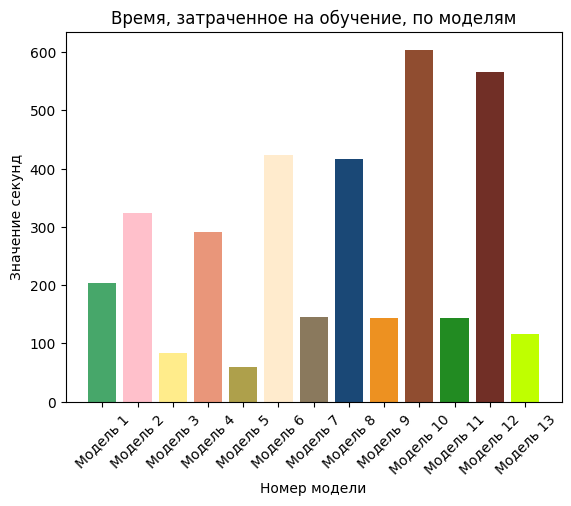

In [ ]:
colors = ['#47A76A', '#FFC0CB', '#FFEC8B', '#E9967A', '#AEA04B', '#FFEBCD', '#8A795D', '#1A4876', '#ED9121', '#904D30', '#228B22', '#712F26', '#BFFF00']
labels = data.keys()
values = data.values()

plt.bar(labels, values, color=colors)
plt.xlabel('Номер модели')
plt.ylabel('Значение секунд')
plt.title('Время, затраченное на обучение, по моделям')
plt.xticks(rotation=45)
plt.show()

In [ ]:
for i, el in enumerate(copy):
  data[f'Модель {i+1}'] = el[9]
print(data)

{'Модель 1': 0.9178, 'Модель 2': 0.8762, 'Модель 3': 0.8545, 'Модель 4': 0.9273, 'Модель 5': 0.9247, 'Модель 6': 0.8617, 'Модель 7': 0.853, 'Модель 8': 0.8781, 'Модель 9': 0.8893, 'Модель 10': 0.91, 'Модель 11': 0.8657, 'Модель 12': 0.9514, 'Модель 13': 0.9255}


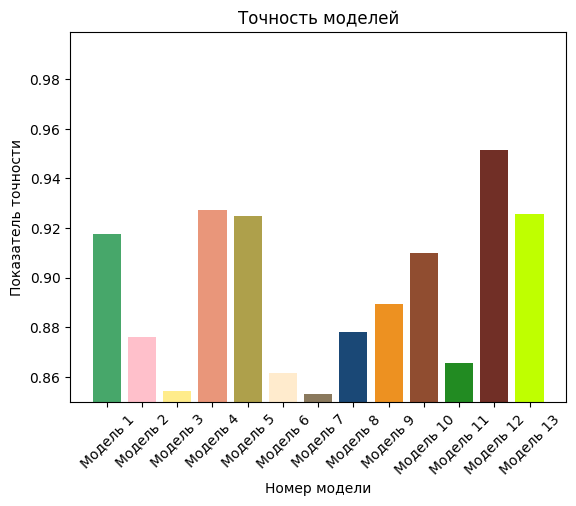

In [ ]:
labels = data.keys()
values = data.values()

plt.bar(labels, values, color=colors)
plt.xlabel('Номер модели')
plt.ylabel('Показатель точности')
plt.title('Точность моделей')
plt.xticks(rotation=45)
plt.ylim(0.85)
plt.show()

In [ ]:
for i in range(13):
  print('Модель', i+1, 'Доля правильных ответов на обучающей выборке:', acc[i],
        'Доля правильных ответов на проверочной выборке:', val_acc[i],
        'Доля ошибок на обучающей выборке:', loss[i],
        'Доля ошибок на проверочной выборке:', val_loss[i])

Модель 1 Доля правильных ответов на обучающей выборке: [0.9794591069221497, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Доля правильных ответов на проверочной выборке: [0.9447488784790039, 0.9347031712532043, 0.9164383411407471, 0.9182648658752441, 0.9136986136436462, 0.9228310585021973, 0.9182648658752441, 0.9182648658752441, 0.9173516035079956, 0.9264839887619019, 0.9237443208694458, 0.921004593372345, 0.9237443208694458, 0.9105022549629211, 0.9191780686378479, 0.9178082346916199, 0.9123287796974182, 0.9187214374542236, 0.9205479621887207, 0.9178082346916199] Доля ошибок на обучающей выборке: [0.11003240942955017, 0.00951777957379818, 0.004206424579024315, 0.0024969829246401787, 0.0016800843877717853, 0.0011318499455228448, 0.0009019121644087136, 0.0006840970017947257, 0.0005470669129863381, 0.00042801868403330445, 0.00034056432195939124, 0.0002936806413345039, 0.00028049314278177917, 0.00019831332610920072, 0.00015005898603703827, 0

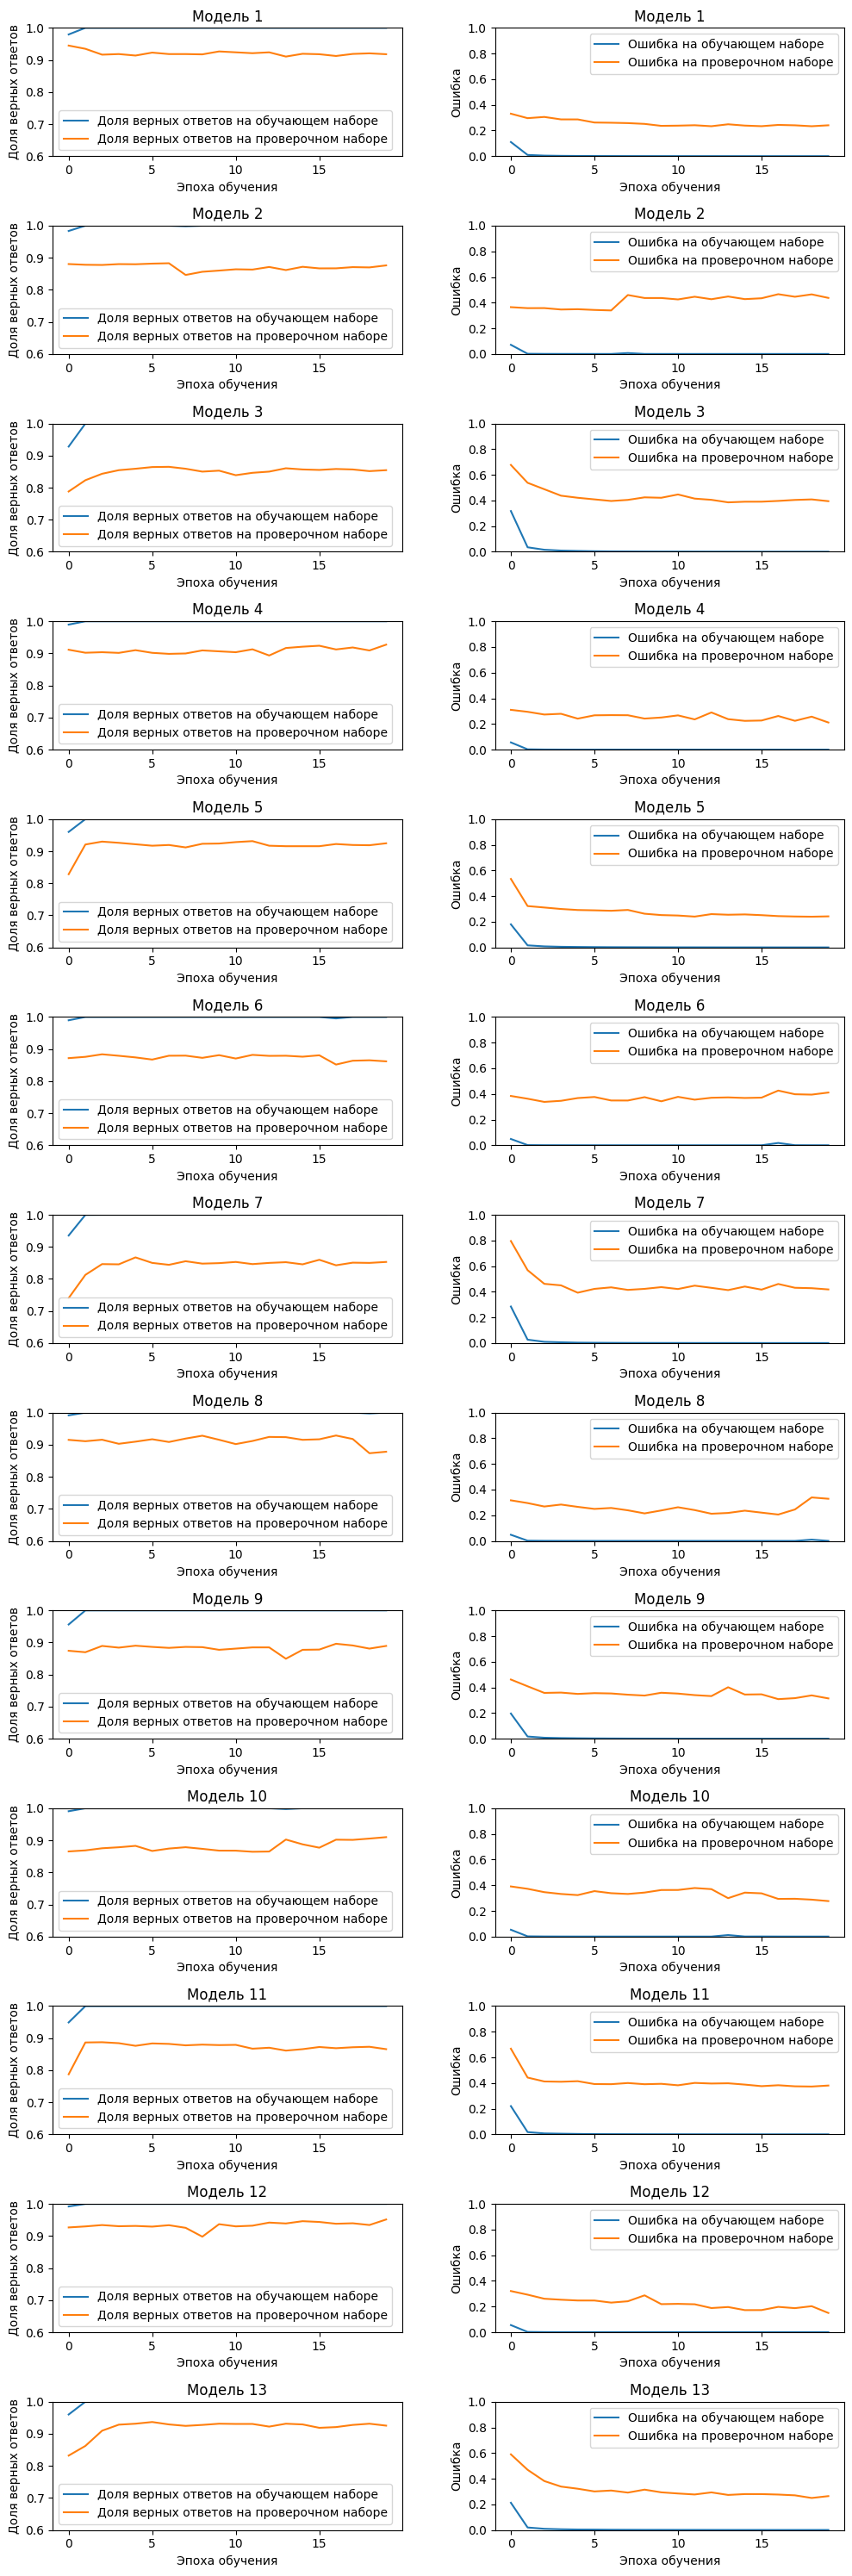

In [ ]:
fig, axes = plt.subplots(nrows=13, ncols=2, figsize=(10, 30))

for i in range(13):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]

    ax1.plot(acc[i], label='Доля верных ответов на обучающем наборе')
    ax1.plot(val_acc[i], label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.set_title('Модель {}'.format(i+1))
    ax1.set_ylim([0.6,1])
    ax1.legend()

    ax2.plot(loss[i], label='Ошибка на обучающем наборе')
    ax2.plot(val_loss[i], label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.set_title('Модель {}'.format(i+1))
    ax2.set_ylim([0,1])
    ax2.legend()

plt.tight_layout()
plt.show()